<a href="https://colab.research.google.com/github/chaniestudy/PyTorch_Tutorials/blob/main/catsanddogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from google.colab import drive
drive.mount('/content/gdrive')
!pip install kaggle
from google.colab import files
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaniestudy","key":"346f13865da2952fd9373f60982bdc8f"}'}

In [3]:
ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         88           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        182           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        307           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2298           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      17661           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4812           False  
connectx

In [5]:
! kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.5MB/s]
 98% 535M/543M [00:05<00:00, 146MB/s]
100% 543M/543M [00:06<00:00, 93.7MB/s]
 99% 269M/271M [00:03<00:00, 106MB/s] 
100% 271M/271M [00:03<00:00, 85.6MB/s]


In [6]:
!ls

gdrive	kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train.zip


In [7]:
! unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [8]:
! unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



[Epoch 1/1] Iteration 200 -> Train Loss: 0.7365, Accuracy: 0.562
[Epoch 1/1] Iteration 400 -> Train Loss: 0.5490, Accuracy: 1.000
[Epoch 1/1] Iteration 600 -> Train Loss: 0.4323, Accuracy: 0.812
[Epoch 1/1] Iteration 800 -> Train Loss: 0.3066, Accuracy: 1.000
[Epoch 1/1] Iteration 1000 -> Train Loss: 0.2601, Accuracy: 0.875
[Epoch 1/1] Iteration 1200 -> Train Loss: 0.2433, Accuracy: 0.938
[Epoch 1/1] Iteration 1400 -> Train Loss: 0.2067, Accuracy: 0.750


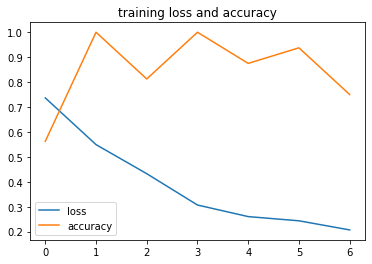

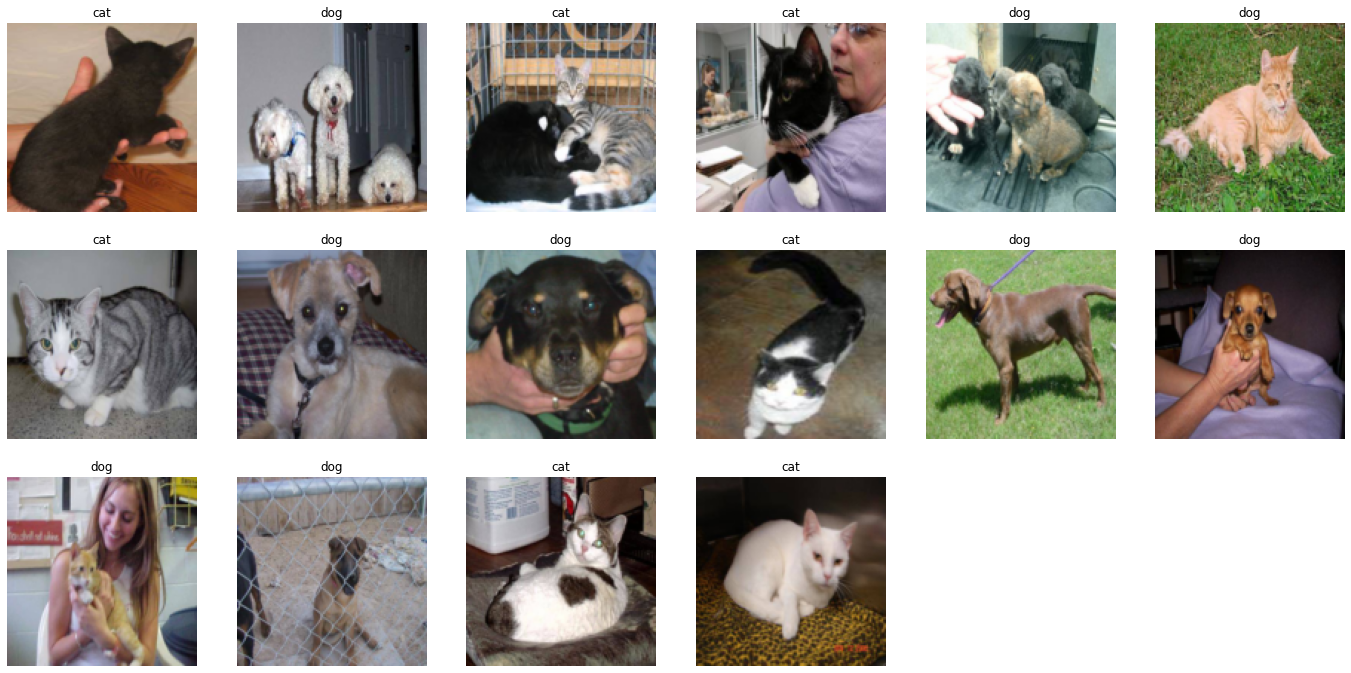

In [9]:
import matplotlib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

torch.cuda.empty_cache()


# 문제의 정의
# 데이터 준비
# 데이터 전처리
# 모델 선정, 최종레이어 선정
# Optimizer, 평가 지표 선택
# 학습

train_dir = 'train'
test_dir = 'test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# 1 데이터셋을 준비할 때에는 클래스 형태로 짜고 init, len, getitem이 꼭 있어야한다.
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform=None):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

# 2 데이터 전처리
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform=data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform=data_transform)

catdogs = ConcatDataset([cats, dogs])

dataloader = DataLoader(catdogs, batch_size = 16, shuffle=True, num_workers=4) # 전처리가 끝나면 이제 배치 단위로 올려줄 준비

# torch.multiprocessing.freeze_support()
# samples, labels = next(iter(dataloader))
# plt.figure(figsize=(16,24))
# grid_imgs = torchvision.utils.make_grid(samples[:24])
# np_grid_imgs = grid_imgs.numpy()
# # Tensor와 Numpy의 차원을 이루는 순서가 다르다고 하여, numpy화 해야함
# # in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
# plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# 3 모델 생성하기
device = 'cuda'
model = torchvision.models.densenet121(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
) # 마지막 레이어 수정

model = model.to(device)
criterion = nn.CrossEntropyLoss() # 분류 문제, 평가 지표 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True) # 최적화 함수 설정
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5) # Learnig Rate -> Multistep

# 4 훈련 시키기

if __name__ == '__main__':
    torch.multiprocessing.freeze_support()

    epochs = 1; itr = 1; p_itr = 200 # epoch 설정,
    model.train()
    total_loss = 0
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for samples, labels in dataloader:
            samples, labels = samples.to(device), labels.to(device) # 데이터의 Tensor 화
            optimizer.zero_grad() # gradient intialize: gradient 축적되면 안됨, 비워주는 작업
            output = model(samples) # 결과물, Prediction
            loss = criterion(output, labels) # Loss 계산
            loss.backward() # 역전파
            optimizer.step() # 파라미터 업데이트
            total_loss += loss.item()
            scheduler.step() # LR 업데이트

            if itr % p_itr == 0:
                pred = torch.argmax(output, dim=1)
                correct = pred.eq(labels)
                acc = torch.mean(correct.float())
                print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch + 1, epochs, itr,
                                                                                                  total_loss / p_itr, acc))
                loss_list.append(total_loss / p_itr)
                acc_list.append(acc)
                total_loss = 0

            itr += 1

    plt.plot(loss_list, label='loss')
    plt.plot(acc_list, label='accuracy')
    plt.legend()
    plt.title('training loss and accuracy')
    plt.show()

    # 모델 평가

    filename_pth = 'ckpt_densenet121_catdog.pth'
    torch.save(model.state_dict(), filename_pth)

    test_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
        # test 용 데이터는 Resize만 한다
    ])

    testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
    testloader = DataLoader(testset, batch_size = 16, shuffle=False, num_workers=4)

    model.eval()
    fn_list = []
    pred_list = []
    for x, fn in testloader:
        with torch.no_grad():
            x = x.to(device)
            output = model(x)
            pred = torch.argmax(output, dim=1)
            fn_list += [n[:-4] for n in fn]
            pred_list += [p.item() for p in pred]

    submission = pd.DataFrame({"id": fn_list, "label": pred_list})
    submission.to_csv('preds_densenet121.csv', index=False)

    samples, _ = iter(testloader).next()
    samples = samples.to(device)
    fig = plt.figure(figsize=(24, 16))
    fig.tight_layout()
    output = model(samples[:24])
    pred = torch.argmax(output, dim=1)
    pred = [p.item() for p in pred]
    ad = {0: 'cat', 1: 'dog'}
    for num, sample in enumerate(samples[:24]):
        plt.subplot(4, 6, num + 1)
        plt.title(ad[pred[num]])
        plt.axis('off')
        sample = sample.cpu().numpy()
        plt.imshow(np.transpose(sample, (1, 2, 0)))

In [10]:
! nvidia-smi

Fri Jan  1 07:59:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    41W / 300W |   2083MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------